In [1]:
import pandas as pd
import selfies as sf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pytorch_lightning as pl
from rxitect.chem.utils import batch_calc_fp, calc_fp, calc_ecfp, calc_physchem
from rdkit import Chem
from rdkit.Chem import PandasTools, AllChem
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error

/home/julius/miniconda3/envs/rxt-dev/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda"

In [3]:
def predict_smiles(model, smiles, scaler):
    fp =calc_fp(Chem.MolFromSmiles(smiles)).reshape(1,-1)
    fp_filtered = feature_select.transform(fp)
    fp_tensor = torch.tensor(fp_filtered, device=device).float()
    prediction = model(fp_tensor)
    #return prediction.cpu().detach().numpy()
    pchembl_value = scaler.inverse_transform(prediction.cpu().detach().numpy())
    return pchembl_value[0][0]

def safe_smiles_to_selfies(smiles):
    try:
        return sf.encoder(smiles)
    except sf.EncoderError:
        pass

def flatten(tensor):
    return tensor.cpu().detach().numpy().flatten()

In [4]:
class PchemblRegressor(pl.LightningModule):
    def __init__(self, input_size, hidden_size, dropout_rate, out_size, lr, scaler):
        super(PchemblRegressor, self).__init__()
        # Three layers and a output layer
        self.fc1 = nn.Linear(input_size, hidden_size)  # 1st Full-Connected Layer
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc_out = nn.Linear(hidden_size, out_size) # Output layer
        #Layer normalization for faster training
        self.ln1 = nn.LayerNorm(hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)
        self.ln3 = nn.LayerNorm(hidden_size)        
        #LeakyReLU will be used as the activation function
        self.activation = nn.LeakyReLU()
        #Dropout for regularization
        self.dropout = nn.Dropout(dropout_rate)
        self.criterion = nn.MSELoss()
        self.lr = lr
        self.scaler = scaler
        
    def training_step(self, batch, batch_idx):
        scaled_placeholder = self.scaler.transform(np.array([3.99]).reshape(1, -1)).item()
        x, y = batch
        output = self(x)
        weight = torch.zeros(y.size(), device=self.device)
        down_idx = (y == scaled_placeholder)
        up_idx = (y != scaled_placeholder)
        weight[down_idx] = 0.05
        weight[up_idx] = 1
        loss = self.criterion(output * weight, y * weight)
        return loss
     
    def forward(self, x):# Forward pass: stacking each layer together
        # Fully connected =&amp;gt; Layer Norm =&amp;gt; LeakyReLU =&amp;gt; Dropout times 3
        out = self.fc1(x)
        out = self.ln1(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.ln2(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = self.fc3(out)
        out = self.ln3(out)
        out = self.activation(out)
        out = self.dropout(out)
        #Final output layer
        out = self.fc_out(out)
        return out
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        return self(batch)
    
    def predict_smiles(self, smiles):
        fp =calc_fp(Chem.MolFromSmiles(smiles), radius=3, bit_len=4096).reshape(1,-1)
        fp_filtered = feature_select.transform(fp)
        fp_tensor = torch.tensor(fp_filtered, device=device, dtype=torch.float32)
        prediction = self(fp_tensor)
        pchembl_value = self.scaler.inverse_transform(prediction.cpu().detach().numpy())
        return pchembl_value[0][0]
    
    def predict_selfies(self, selfies):
        smiles = sf.encoder(selfies)
        fp =calc_fp(Chem.MolFromSmiles(smiles)).reshape(1,-1)
        fp_filtered = feature_select.transform(fp)
        fp_tensor = torch.tensor(fp_filtered, device=device, dtype=torch.float32)
        prediction = self(fp_tensor)
        pchembl_value = self.scaler.inverse_transform(prediction.cpu().detach().numpy())
        return pchembl_value[0][0]


In [5]:
df = pd.read_parquet("../data/processed/CHEMBL240_dataset_xuhan.pq")
df = df.dropna(subset=['pchembl value'])
PandasTools.AddMoleculeColumnToFrame(df, 'smiles', 'mol')
df['fingerprint'] = df.mol.apply(calc_fp, args=(3, 4096))
timeidx_test = (df['document year'] > 2015).values
timeidx_train = (df['document year'] <= 2015).values

X = np.stack(df.fingerprint.values)
y = df['pchembl value'].values.reshape((-1, 1))

In [6]:
# X_train, X_test, y_train, y_test = X[timeidx_train], X[timeidx_test], y[timeidx_train], y[timeidx_test]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

In [8]:
feature_select = VarianceThreshold(threshold=0.05)
X_train = feature_select.fit_transform(X_train)
X_test = feature_select.transform(X_test)

In [9]:
X_scaler = MinMaxScaler()
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)

In [10]:
X_train = torch.tensor(X_train, device=device, dtype=torch.float32)
X_test = torch.tensor(X_test, device=device, dtype=torch.float32)
y_train = torch.tensor(y_train, device=device, dtype=torch.float32)
y_test = torch.tensor(y_test, device=device, dtype=torch.float32)

In [11]:
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)

In [12]:
input_size = X_train.size()[-1]
hidden_size = 1024
dropout_rate = 0.8
out_size = 1
learning_rate = 0.001

In [13]:
reg = PchemblRegressor(input_size, hidden_size, dropout_rate, out_size, learning_rate, scaler)
reg.cuda()

PchemblRegressor(
  (fc1): Linear(in_features=204, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc_out): Linear(in_features=1024, out_features=1, bias=True)
  (ln1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (ln2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (ln3): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (activation): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.8, inplace=False)
  (criterion): MSELoss()
)

In [14]:
trainer = pl.Trainer(gpus=1, max_epochs=200)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [15]:
trainer.fit(model=reg, train_dataloaders=train_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | fc1        | Linear    | 209 K 
1 | fc2        | Linear    | 1.0 M 
2 | fc3        | Linear    | 1.0 M 
3 | fc_out     | Linear    | 1.0 K 
4 | ln1        | LayerNorm | 2.0 K 
5 | ln2        | LayerNorm | 2.0 K 
6 | ln3        | LayerNorm | 2.0 K 
7 | activation | LeakyReLU | 0     
8 | dropout    | Dropout   | 0     
9 | criterion  | MSELoss   | 0     
-----------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.265     Total estimated model params size (MB)
/home/julius/miniconda3/envs/rxt-dev/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine

Epoch 199: 100%|█| 39/39 [00:00<00:00, 150.88it/s, loss=0.105,


In [16]:
scaled_px = scaled_placeholder = reg.scaler.transform(np.array([3.99]).reshape(1, -1)).item()

to_keep_train = (y_train != scaled_px)
y_train_clean = y_train[to_keep_train]
X_train_clean = X_train[to_keep_train.reshape(-1)]

to_keep_test = (y_test != scaled_px)
y_test_clean = y_test[to_keep_test]
X_test_clean = X_test[to_keep_test.reshape(-1)]

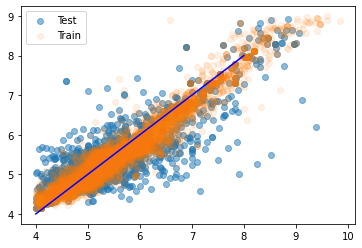

In [17]:
reg.cuda()
reg.eval()
y_pred_train = reg(X_train_clean)
y_pred_test = reg(X_test_clean)

plt.scatter(y=scaler.inverse_transform(y_pred_test.cpu().detach().numpy()).reshape(-1), x=scaler.inverse_transform(y_test_clean.cpu().detach().numpy().reshape(-1, 1)), alpha=0.5, label="Test")
plt.scatter(y=scaler.inverse_transform(y_pred_train.cpu().detach().numpy()).reshape(-1), x=scaler.inverse_transform(y_train_clean.cpu().detach().numpy().reshape(-1, 1)), alpha=0.1, label="Train")
plt.legend()
plt.plot()
plt.plot([4, 8], [4,8], c="b")

In [18]:
r2_test = r2_score(y_test_clean.cpu(), y_pred_test.detach().cpu())
r2_train = r2_score(y_train_clean.cpu(), y_pred_train.detach().cpu())
print(f"TEST R2: {r2_test}\nTRAIN R2: {r2_train}")

TEST R2: 0.7272127171319707
TRAIN R2: 0.9233021596162739


In [19]:
rmse_test = mean_squared_error(y_test_clean.cpu(), y_pred_test.detach().cpu(), squared=False)
rmse_train = mean_squared_error(y_train_clean.cpu(), y_pred_train.detach().cpu(), squared=False)
print(f"TEST RMSE: {rmse_test}\nTRAIN RMSE: {rmse_train}")

TEST RMSE: 0.47188887000083923
TRAIN RMSE: 0.24876442551612854


In [20]:
df['pchembl value'].min()

3.99